In [1]:
import os
import sys

import numpy  as np
import tables as tb
import pandas as pd
import matplotlib
import math

#the line below makes the plot as a pop-up, that can be saved
#matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import matplotlib.cm as cm
from matplotlib.colors import Normalize

from scipy.stats import norm
from scipy.stats import exponnorm
from scipy.stats import skewnorm


from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.core.exceptions import NoHits

In [2]:
import functions.histo_functions as myhf
import functions.efficiency_functions as myef
import functions.recovstrue as myrvt

In [3]:
#Dimensions for the NEXT100 detector
veto_N100 = 20 # mm
rmax_N100 = 492 - veto_N100
#rmax_N100 = 200
zmin_N100 = veto_N100
zmax_N100 = 1205 - veto_N100

In [4]:
filepath = '/Users/halmamol/NEXT/files/NEXT100/beershebaDS_202012/'
max0nubbf = 999
maxselectron = 999
blobR = 21
testID = '_202012'

## Opening TRACK Files - 0nubb

In [5]:
#0nubb files
track_list_0nubb = []

filepath_0nubb_tracks = filepath+f'0nubb/tracks/{blobR}mm/'

#loop over all the files, to read 'Tracks' information
for nfile in range(1,max0nubbf):
    
    filename_0nubb = filepath_0nubb_tracks+f'next100.0nubb.{nfile}.skel_tracks.R{blobR}mm.h5'
    #the following lines are added because some of the files aren't there (I had to check Paola's notebook)
    try:
        readfile_tracks = pd.read_hdf(filename_0nubb, 'Tracks')
    except:
        print('File {} not good'.format(filename_0nubb))
        continue
        
    track_list_0nubb.append(readfile_tracks)
    

#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

tracks_0nubb = pd.concat([dt for dt in track_list_0nubb]) 
tracks_0nubb.columns  
#these are all the elements inside the file:

Index(['event', 'trackID', 'energy', 'length', 'numb_of_voxels',
       'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'x_max',
       'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'extreme1_x',
       'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z',
       'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z',
       'eblob1', 'eblob2', 'ovlp_blob_energy', 'vox_size_x', 'vox_size_y',
       'vox_size_z'],
      dtype='object')

In [6]:
#same for selectron files
track_list_selectron = []
filepath_selectron_tracks = filepath+f'/e-_roi/tracks/{blobR}mm/'

#loop over all the files, to read 'Tracks' information
for nfile in range(1,maxselectron):
    
    filename_selectron = filepath_selectron_tracks+f'next100.e-_roi.{nfile}.skel_tracks.R{blobR}mm.h5'
    #the following lines are added because some of the files aren't there (I had to check Paola's notebook)
    try:
        readfile_tracks_selectron = pd.read_hdf(filename_selectron, 'Tracks')
    except:
        print('File {} not good'.format(filename_selectron))
        continue
        
    track_list_selectron.append(readfile_tracks_selectron)
    

#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

tracks_selectron = pd.concat([dt for dt in track_list_selectron]) 
tracks_selectron.columns  

#these are all the elements inside the file:

File /Users/halmamol/NEXT/files/NEXT100/beershebaDS_202012//e-_roi/tracks/21mm/next100.e-_roi.31.skel_tracks.R21mm.h5 not good
File /Users/halmamol/NEXT/files/NEXT100/beershebaDS_202012//e-_roi/tracks/21mm/next100.e-_roi.32.skel_tracks.R21mm.h5 not good
File /Users/halmamol/NEXT/files/NEXT100/beershebaDS_202012//e-_roi/tracks/21mm/next100.e-_roi.33.skel_tracks.R21mm.h5 not good
File /Users/halmamol/NEXT/files/NEXT100/beershebaDS_202012//e-_roi/tracks/21mm/next100.e-_roi.34.skel_tracks.R21mm.h5 not good
File /Users/halmamol/NEXT/files/NEXT100/beershebaDS_202012//e-_roi/tracks/21mm/next100.e-_roi.35.skel_tracks.R21mm.h5 not good
File /Users/halmamol/NEXT/files/NEXT100/beershebaDS_202012//e-_roi/tracks/21mm/next100.e-_roi.36.skel_tracks.R21mm.h5 not good
File /Users/halmamol/NEXT/files/NEXT100/beershebaDS_202012//e-_roi/tracks/21mm/next100.e-_roi.37.skel_tracks.R21mm.h5 not good
File /Users/halmamol/NEXT/files/NEXT100/beershebaDS_202012//e-_roi/tracks/21mm/next100.e-_roi.38.skel_tracks.R2

Index(['event', 'trackID', 'energy', 'length', 'numb_of_voxels',
       'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'x_max',
       'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'extreme1_x',
       'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z',
       'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z',
       'eblob1', 'eblob2', 'ovlp_blob_energy', 'vox_size_x', 'vox_size_y',
       'vox_size_z'],
      dtype='object')

## Checking cuts

interested in selecting the events in/with:
- **Fiducial**: fiducial cut around the detector volume, of 2cm from the border
- **1Track**: in this case, considers the track with highest deposition
- **NoOverlap**: defined blobs in one trace should not overlap
- **ROI**: energy cut in the region of interest, between [2.445,2475]MeV

In [7]:
tracks_0nubb_1track = tracks_0nubb[tracks_0nubb.trackID == 0]
tracks_selectron_1track = tracks_selectron[tracks_selectron.trackID == 0]

In [8]:
#Checking total amount of events, prior any selection
nevents_0nubb_total = tracks_0nubb.event.nunique()
Enevents_0nubb_total = np.sqrt(nevents_0nubb_total)
print(f'Initial amount of events for 0nubb: {nevents_0nubb_total} +- {Enevents_0nubb_total}')

Initial amount of events for 0nubb: 9785 +- 98.91915891272023


In [9]:
nevents_selectron_total = tracks_selectron.event.nunique()
Enevents_selectron_total = np.sqrt(nevents_selectron_total)
print(f'Initial amount of events for selectrons: {nevents_selectron_total} +- {Enevents_selectron_total}')

Initial amount of events for selectrons: 9547 +- 97.70875088752287


### 1 - FIDUCIAL CUT

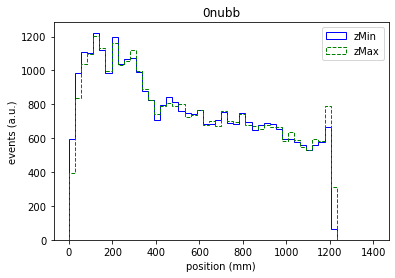

In [10]:
track_0nubb_zmin = tracks_0nubb.z_min
track_0nubb_zmax = tracks_0nubb.z_max

plt.hist(track_0nubb_zmin, bins = 50, range = (0, 1400),  color='blue', histtype='step', label = 'zMin')
plt.hist(track_0nubb_zmax, bins = 50, range = (0, 1400),  color='green', histtype='step', label = 'zMax', linestyle='dashed')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

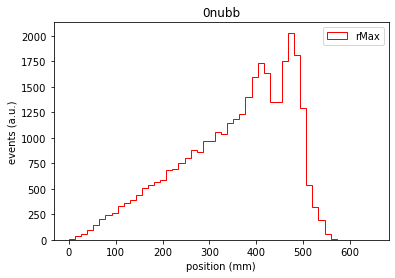

In [11]:
track_0nubb_rmax = tracks_0nubb.r_max

plt.hist(track_0nubb_rmax, bins = 50, range = (0, 650),  color='red', histtype='step', label = 'rMax')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

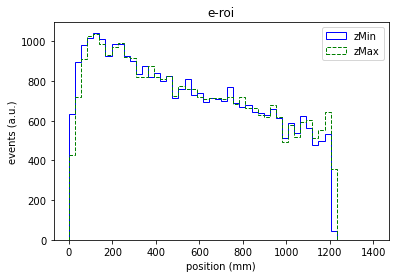

In [12]:
track_selectron_zmin = tracks_selectron.z_min
track_selectron_zmax = tracks_selectron.z_max

plt.hist(track_selectron_zmin, bins = 50, range = (0, 1400),  color='blue', histtype='step', label = 'zMin')
plt.hist(track_selectron_zmax, bins = 50, range = (0, 1400),  color='green', histtype='step', label = 'zMax', linestyle='dashed')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('e-roi')
plt.legend(loc=1);
plt.show()

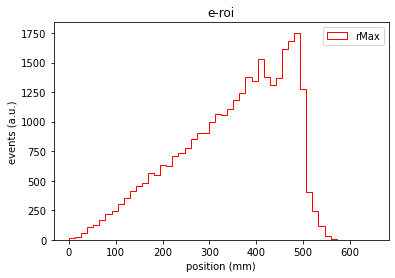

In [13]:
track_selectron_rmax = tracks_selectron.r_max

plt.hist(track_selectron_rmax, bins = 50,  range = (0, 650),  color='red', histtype='step', label = 'rMax')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('e-roi')
plt.legend(loc=1);
plt.show()

In [14]:
print(f'MAX VALUE')
print(f'0nubb')
print(f'- Rmax = {np.amax(track_0nubb_rmax)}')
print(f'- Zmin = {np.amax(track_0nubb_zmin)}')
print(f'- Zmax = {np.amax(track_0nubb_zmax)}')
print(f'e-roi')
print(f'- Rmax = {np.amax(track_selectron_rmax)}')
print(f'- Zmin = {np.amax(track_selectron_zmin)}')
print(f'- Zmax = {np.amax(track_selectron_zmax)}')
print(f'AVG VALUE')
print(f'0nubb')
print(f'- Rmax = {np.average(track_0nubb_rmax)}')
print(f'- Zmin = {np.average(track_0nubb_zmin)}')
print(f'- Zmax = {np.average(track_0nubb_zmax)}')
print(f'e-roi')
print(f'- Rmax = {np.average(track_selectron_rmax)}')
print(f'- Zmin = {np.average(track_selectron_zmin)}')
print(f'- Zmax = {np.average(track_selectron_zmax)}')

MAX VALUE
0nubb
- Rmax = 564.7048443656207
- Zmin = 1207.883875
- Zmax = 1212.6875
e-roi
- Rmax = 563.747338131188
- Zmin = 1209.76475
- Zmax = 1212.67075
AVG VALUE
0nubb
- Rmax = 352.63700510865095
- Zmin = 534.7305105749069
- Zmax = 549.266906827363
e-roi
- Rmax = 348.66692934937015
- Zmin = 539.5041602245598
- Zmax = 557.2112190571515


In [15]:
npz_file = f'/Users/halmamol/NEXT/NBarrays/tracklimits_NEXT100_DETSIM{testID}_lin'
np.savez(npz_file, track_0nubb_zmin=track_0nubb_zmin, track_0nubb_zmax=track_0nubb_zmax, track_0nubb_rmax=track_0nubb_rmax,
        track_selectron_zmin=track_selectron_zmin, track_selectron_zmax=track_selectron_zmax, track_selectron_rmax=track_selectron_rmax)


In [16]:
#For the evaluation of the events out of fiducial limits it's necessary to do several steps

#First, check a list of events where at least 1 trace is out of the limits:

nonfiducial_list_0nubb = tracks_0nubb[~((tracks_0nubb.r_max < rmax_N100) & 
                                     (tracks_0nubb.z_min > zmin_N100) & 
                                     (tracks_0nubb.z_max < zmax_N100))].event.unique()

#Then I apply the selection into the matrix of elements
fiducial_tracks_0nubb = tracks_0nubb[(tracks_0nubb.r_max < rmax_N100) & 
                                     (tracks_0nubb.z_min > zmin_N100) & 
                                     (tracks_0nubb.z_max < zmax_N100)]

# I get a list of true elements if event ID is not in the above list 'nonfiducial_list'
evt_fid_sel_0nubb    = ~fiducial_tracks_0nubb.event.isin(nonfiducial_list_0nubb) 

# And finally I select the events with an asigned True from the previous line 
tracks_0nubb_fiducial = fiducial_tracks_0nubb[evt_fid_sel_0nubb]

In [17]:
#Now I do the same for single electron

nonfiducial_list_selectron = tracks_selectron[~((tracks_selectron.r_max < rmax_N100) & 
                                     (tracks_selectron.z_min > zmin_N100) & 
                                     (tracks_selectron.z_max < zmax_N100))].event.unique()

#Then I apply the selection into the matrix of elements
fiducial_tracks_selectron = tracks_selectron[(tracks_selectron.r_max < rmax_N100) & 
                                     (tracks_selectron.z_min > zmin_N100) & 
                                     (tracks_selectron.z_max < zmax_N100)]

# I get a list of true elements if event ID is not in the above list 'nonfiducial_list'
evt_fid_sel_selectron    = ~fiducial_tracks_selectron.event.isin(nonfiducial_list_selectron) 

# And finally I select the events with an asigned True from the previous line 
tracks_selectron_fiducial = fiducial_tracks_selectron[evt_fid_sel_selectron]

In [18]:
#Checking total amount of events, after fiducial selection

nevents_0nubb_fiducial = tracks_0nubb_fiducial.event.nunique()
Enevents_0nubb_fiducial = np.sqrt(nevents_0nubb_fiducial)


ratio_fiducial_0nubb = 100*nevents_0nubb_fiducial/nevents_0nubb_total
Eratio_fiducial_0nubb = myef.ratio_error(ratio_fiducial_0nubb, nevents_0nubb_fiducial, nevents_0nubb_total, 
                                             Enevents_0nubb_fiducial, Enevents_0nubb_total)

print('--------------------------0nubb-------------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_0nubb_total}        ')
print(f'FIDUCIAL   {nevents_0nubb_fiducial}                ---      {ratio_fiducial_0nubb} +- {Eratio_fiducial_0nubb}%')
print('--------!--------------!----------------!----------------')


--------------------------0nubb-------------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9785        
FIDUCIAL   6679                ---      68.25753704649975 +- 1.0833833465375287%
--------!--------------!----------------!----------------


In [19]:
nevents_selectron_fiducial = tracks_selectron_fiducial.event.nunique()
Enevents_selectron_fiducial = np.sqrt(nevents_selectron_fiducial)

ratio_fiducial_selectron = 100*nevents_selectron_fiducial/nevents_selectron_total
Eratio_fiducial_selectron = myef.ratio_error(ratio_fiducial_selectron, nevents_selectron_fiducial, nevents_selectron_total, 
                                             Enevents_selectron_fiducial, Enevents_selectron_total)

print('--------------------------SElectron---------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_selectron_total}        ')
print(f'FIDUCIAL   {nevents_selectron_fiducial}                ---      {ratio_fiducial_selectron} +- {Eratio_fiducial_selectron}%')
print('--------!--------------!----------------!----------------')


--------------------------SElectron---------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9547        
FIDUCIAL   6293                ---      65.9159945532628 +- 1.0703013436881332%
--------!--------------!----------------!----------------


## 2 - Number of tracks

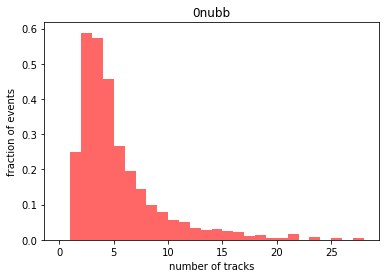

In [20]:
#Check the number of tracks with numb_of_tracks
ntracks_0nubb = tracks_0nubb_fiducial.numb_of_tracks
maxtracks_0nubb = np.amax(ntracks_0nubb)

weights_0nubb = np.ones_like(ntracks_0nubb)/nevents_0nubb_fiducial

plt.hist(ntracks_0nubb, weights=weights_0nubb, bins = maxtracks_0nubb, range = (0, maxtracks_0nubb), alpha=0.6, color='r')
plt.xlabel('number of tracks')
plt.ylabel('fraction of events')
plt.title('0nubb')
plt.show()

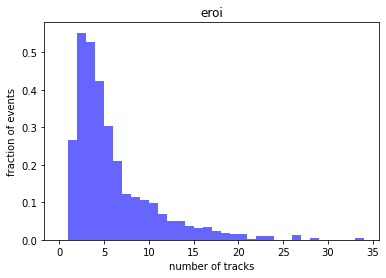

In [21]:
#Check the number of tracks with numb_of_tracks
ntracks_eroi = tracks_selectron_fiducial.numb_of_tracks
maxtracks_eroi = np.amax(ntracks_eroi)

weights_eroi = np.ones_like(ntracks_eroi)/nevents_selectron_fiducial

plt.hist(ntracks_eroi,weights=weights_eroi ,bins = maxtracks_eroi, range = (0, maxtracks_eroi),  alpha=0.6, color='b')
plt.xlabel('number of tracks')
plt.ylabel('fraction of events')
plt.title('eroi')
plt.show()

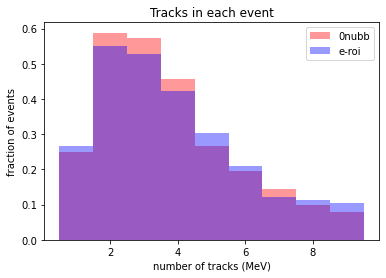

In [22]:
plt.hist(ntracks_0nubb, bins = 9, range = (0.5, 9.5),weights=weights_0nubb,alpha=0.4, color='r', label = '0nubb')
plt.hist(ntracks_eroi, bins = 9, range = (0.5, 9.5), weights=weights_eroi, alpha=0.4, color='b',label = 'e-roi')

plt.xlabel('number of tracks (MeV)')
plt.ylabel('fraction of events')
plt.title('Tracks in each event')
plt.legend(loc=1);
plt.show()

In [23]:
#Therefore, I'm going to take the 1st 'trackID'

tracks_0nubb_1track = tracks_0nubb[tracks_0nubb.numb_of_tracks == 1]
tracks_0nubb_1trackfid = tracks_0nubb_fiducial[tracks_0nubb_fiducial.numb_of_tracks == 1]

#tracks_0nubb_1track = tracks_0nubb[tracks_0nubb.trackID == 0]
#tracks_0nubb_1trackfid = tracks_0nubb_fiducial[tracks_0nubb_fiducial.trackID == 0]

In [24]:
tracks_selectron_1track = tracks_selectron[tracks_selectron.numb_of_tracks == 1]
tracks_selectron_1trackfid = tracks_selectron_fiducial[tracks_selectron_fiducial.numb_of_tracks == 1]

#tracks_selectron_1track = tracks_selectron[tracks_selectron.trackID == 0]
#tracks_selectron_1trackfid = tracks_selectron_fiducial[tracks_selectron_fiducial.trackID == 0]

In [25]:
print(f'MAX VALUE')
print(f'0nubb')
print(f'- #tracks = {np.amax(ntracks_0nubb)}')
print(f'e-roi')
print(f'- #tracks = {np.amax(ntracks_eroi)}')
print(f'AVG VALUE')
print(f'0nubb')
print(f'- #tracks = {np.average(ntracks_0nubb)}')
print(f'e-roi')
print(f'- #tracks = {np.average(ntracks_eroi)}')
print(f'1-track events')
print(f'0nubb')
print(f'- 1 track = {100*(tracks_0nubb[tracks_0nubb.numb_of_tracks == 1].event.nunique())/(tracks_0nubb.event.nunique())}')
print(f'e-roi')
print(f'- 1 track = {100*(tracks_selectron[tracks_selectron.numb_of_tracks == 1].event.nunique())/(tracks_selectron.event.nunique())}')


MAX VALUE
0nubb
- #tracks = 28
e-roi
- #tracks = 34
AVG VALUE
0nubb
- #tracks = 4.8481511416447765
e-roi
- #tracks = 5.509659613615455
1-track events
0nubb
- 1 track = 20.521205927439958
e-roi
- 1 track = 25.348276945637373


In [26]:
tracks_0nubb_1track_cut = tracks_0nubb_1trackfid[tracks_0nubb_1trackfid.numb_of_tracks == 1]
frac_1track_0nubb = 100*tracks_0nubb_1track_cut.event.nunique()/nevents_0nubb_fiducial

Efrac_1track_0nubb = myef.ratio_error(frac_1track_0nubb, tracks_0nubb_1track_cut.event.nunique(), nevents_0nubb_fiducial, 
                                             np.sqrt(tracks_0nubb_1track_cut.event.nunique()), np.sqrt(nevents_0nubb_fiducial))
print(f'Amount of events with 1 track 0nubb = {tracks_0nubb_1track_cut.event.nunique()}/{nevents_0nubb_fiducial} = {frac_1track_0nubb} +- {Efrac_1track_0nubb}')

Amount of events with 1 track 0nubb = 1664/6679 = 24.913909267854468 +- 0.6826068113927476


In [27]:
tracks_selectron_1track_cut = tracks_selectron_1trackfid[tracks_selectron_1trackfid.numb_of_tracks == 1]
frac_1track_selectron = 100*tracks_selectron_1track_cut.event.nunique()/nevents_selectron_fiducial
Efrac_1track_selectron = myef.ratio_error(frac_1track_selectron, tracks_selectron_1track_cut.event.nunique(), nevents_selectron_fiducial, 
                                             np.sqrt(tracks_selectron_1track_cut.event.nunique()), np.sqrt(nevents_selectron_fiducial))
print(f'Amount of events with 1 track eroi = {frac_1track_selectron} +- {Efrac_1track_selectron}')

Amount of events with 1 track eroi = 26.696329254727473 +- 0.7331265122346172


In [28]:
#Checking total amount of events, after fiducial selection

nevents_0nubb_1track = tracks_0nubb_1track.event.nunique()
Enevents_0nubb_1track = np.sqrt(nevents_0nubb_1track)
nevents_0nubb_1trackfid = tracks_0nubb_1trackfid.event.nunique()
Enevents_0nubb_1trackfid = np.sqrt(nevents_0nubb_1trackfid)


ratio_1trackfid_0nubb = 100*nevents_0nubb_1trackfid/nevents_0nubb_fiducial
Eratio_1trackfid_0nubb = myef.ratio_error(ratio_1trackfid_0nubb, nevents_0nubb_1trackfid, nevents_0nubb_fiducial, 
                                             Enevents_0nubb_1trackfid, Enevents_0nubb_fiducial)

eff_1trackfid_0nubb = 100*nevents_0nubb_1trackfid/nevents_0nubb_total
Eeff_1trackfid_0nubb = myef.ratio_error(eff_1trackfid_0nubb, nevents_0nubb_1trackfid, nevents_0nubb_total, 
                                             Enevents_0nubb_1trackfid, Enevents_0nubb_total)


print('--------------------------0nubb-------------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_0nubb_total}        ')
print(f'FIDUCIAL   {nevents_0nubb_fiducial}                ---      {ratio_fiducial_0nubb} +- {Eratio_fiducial_0nubb}%')
print(f'1TRACK.    {nevents_0nubb_1trackfid}        {ratio_1trackfid_0nubb}+- {Eratio_1trackfid_0nubb}% {eff_1trackfid_0nubb} +- {Eeff_1trackfid_0nubb}%')

print('--------!--------------!----------------!----------------')


--------------------------0nubb-------------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9785        
FIDUCIAL   6679                ---      68.25753704649975 +- 1.0833833465375287%
1TRACK.    1664        24.913909267854468+- 0.6826068113927476% 17.005620848237097 +- 0.4509404497763844%
--------!--------------!----------------!----------------


In [29]:
nevents_selectron_1track = tracks_selectron_1track.event.nunique()
Enevents_selectron_1track = np.sqrt(nevents_selectron_1track)
nevents_selectron_1trackfid = tracks_selectron_1trackfid.event.nunique()
Enevents_selectron_1trackfid = np.sqrt(nevents_selectron_1trackfid)

ratio_1trackfid_selectron = 100*nevents_selectron_1trackfid/nevents_selectron_fiducial
Eratio_1trackfid_selectron = myef.ratio_error(ratio_1trackfid_0nubb, nevents_selectron_1trackfid, nevents_selectron_fiducial, 
                                             Enevents_selectron_1trackfid, Enevents_selectron_fiducial)

eff_1trackfid_selectron = 100*nevents_selectron_1trackfid/nevents_selectron_total
Eeff_1trackfid_selectron = myef.ratio_error(eff_1trackfid_selectron, nevents_selectron_1trackfid, nevents_selectron_total, 
                                             Enevents_selectron_1trackfid, Enevents_selectron_total)

print('--------------------------SElectron---------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_selectron_total}        ')
print(f'FIDUCIAL   {nevents_selectron_fiducial}                ---      {ratio_fiducial_selectron} +- {Eratio_fiducial_selectron}%')
print(f'1TRACK.    {nevents_selectron_1trackfid}        {ratio_1trackfid_selectron}+- {Eratio_1trackfid_selectron}% {eff_1trackfid_selectron} +- {Eeff_1trackfid_selectron}%')
print('--------!--------------!----------------!----------------')


--------------------------SElectron---------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9547        
FIDUCIAL   6293                ---      65.9159945532628 +- 1.0703013436881332%
1TRACK.    1680        26.696329254727473+- 0.6841782341457081% 17.597150937467266 +- 0.4655712119033691%
--------!--------------!----------------!----------------


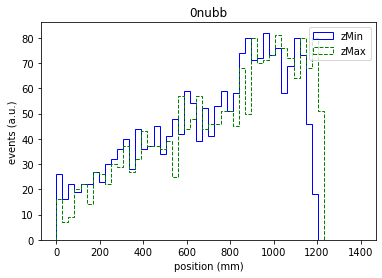

In [30]:
track_0nubb_zmin = tracks_0nubb_1track.z_min
track_0nubb_zmax = tracks_0nubb_1track.z_max

plt.hist(track_0nubb_zmin, bins = 50, range = (0, 1400),  color='blue', histtype='step', label = 'zMin')
plt.hist(track_0nubb_zmax, bins = 50, range = (0, 1400),  color='green', histtype='step', label = 'zMax', linestyle='dashed')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

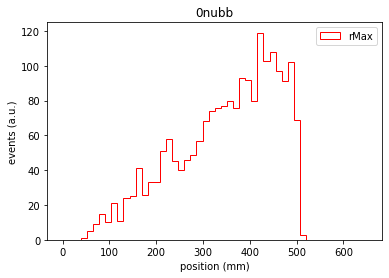

In [31]:
track_0nubb_rmax = tracks_0nubb_1track.r_max

plt.hist(track_0nubb_rmax, bins = 50, range = (0, 650),  color='red', histtype='step', label = 'rMax')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

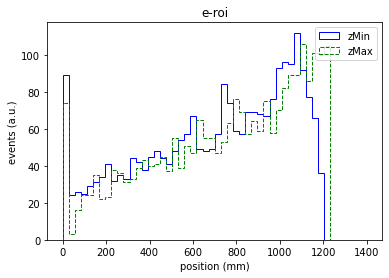

In [32]:
track_selectron_zmin = tracks_selectron_1track.z_min
track_selectron_zmax = tracks_selectron_1track.z_max

plt.hist(track_selectron_zmin, bins = 50, range = (0, 1400),  color='blue', histtype='step', label = 'zMin')
plt.hist(track_selectron_zmax, bins = 50, range = (0, 1400),  color='green', histtype='step', label = 'zMax', linestyle='dashed')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('e-roi')
plt.legend(loc=1);
plt.show()



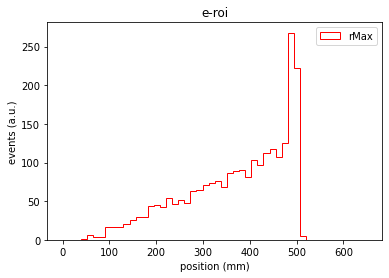

In [33]:
track_selectron_rmax = tracks_selectron_1track.r_max

plt.hist(track_selectron_rmax, bins = 50,  range = (0, 650),  color='red', histtype='step', label = 'rMax')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('e-roi')
plt.legend(loc=1);
plt.show()

## 3 - No overlap

In [34]:
#Getting ovlp variable of the tracks, and selecting events with no ovlp

tracks_0nubb_ovlp = tracks_0nubb[tracks_0nubb.ovlp_blob_energy == 0.]
tracks_0nubb_ovlp1trackfid = tracks_0nubb_1trackfid[tracks_0nubb_1trackfid.ovlp_blob_energy == 0.]

In [35]:
tracks_selectron_ovlp = tracks_selectron[tracks_selectron.ovlp_blob_energy == 0.]
tracks_selectron_ovlp1trackfid = tracks_selectron_1trackfid[tracks_selectron_1trackfid.ovlp_blob_energy == 0.]

In [36]:
#Checking total amount of events, after overlap selection

nevents_0nubb_ovlp = tracks_0nubb_ovlp.event.nunique()
Enevents_0nubb_ovlp = np.sqrt(nevents_0nubb_ovlp)
nevents_0nubb_ovlp1trackfid = tracks_0nubb_ovlp1trackfid.event.nunique()
Enevents_0nubb_ovlp1trackfid = np.sqrt(nevents_0nubb_ovlp1trackfid)


ratio_ovlp1trackfid_0nubb = 100*nevents_0nubb_ovlp1trackfid/nevents_0nubb_1trackfid
Eratio_ovlp1trackfid_0nubb = myef.ratio_error(ratio_ovlp1trackfid_0nubb, nevents_0nubb_ovlp1trackfid, nevents_0nubb_1trackfid, 
                                             Enevents_0nubb_ovlp1trackfid, Enevents_0nubb_1trackfid)

eff_ovlp1trackfid_0nubb = 100*nevents_0nubb_ovlp1trackfid/nevents_0nubb_total
Eeff_ovlp1trackfid_0nubb = myef.ratio_error(eff_ovlp1trackfid_0nubb, nevents_0nubb_ovlp1trackfid, nevents_0nubb_total, 
                                             Enevents_0nubb_ovlp1trackfid, Enevents_0nubb_total)


print('--------------------------0nubb-------------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_0nubb_total}        ')
print(f'FIDUCIAL   {nevents_0nubb_fiducial}                ---      {ratio_fiducial_0nubb} +- {Eratio_fiducial_0nubb}%')
print(f'1TRACK.    {nevents_0nubb_1trackfid}        {ratio_1trackfid_0nubb}+- {Eratio_1trackfid_0nubb}% {eff_1trackfid_0nubb} +- {Eeff_1trackfid_0nubb}%')
print(f'OVLP       {nevents_0nubb_ovlp1trackfid}        {ratio_ovlp1trackfid_0nubb}+- {Eratio_ovlp1trackfid_0nubb}%   {eff_ovlp1trackfid_0nubb} +- {Eeff_ovlp1trackfid_0nubb}%')
print('--------!--------------!----------------!----------------')

--------------------------0nubb-------------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9785        
FIDUCIAL   6679                ---      68.25753704649975 +- 1.0833833465375287%
1TRACK.    1664        24.913909267854468+- 0.6826068113927476% 17.005620848237097 +- 0.4509404497763844%
OVLP       1467        88.1610576923077+- 3.157378212548764%   14.992335206949413 +- 0.4197480368941494%
--------!--------------!----------------!----------------


In [37]:
nevents_selectron_ovlp = tracks_selectron_ovlp.event.nunique()
Enevents_selectron_ovlp = np.sqrt(nevents_selectron_ovlp)
nevents_selectron_ovlp1trackfid = tracks_selectron_ovlp1trackfid.event.nunique()
Enevents_selectron_ovlp1trackfid = np.sqrt(nevents_selectron_ovlp1trackfid)

ratio_ovlp1trackfid_selectron = 100*nevents_selectron_ovlp1trackfid/nevents_selectron_1trackfid
Eratio_ovlp1trackfid_selectron = myef.ratio_error(ratio_ovlp1trackfid_selectron, nevents_selectron_ovlp1trackfid, nevents_selectron_1trackfid, 
                                             Enevents_selectron_ovlp1trackfid, Enevents_selectron_1trackfid)

eff_ovlp1trackfid_selectron = 100*nevents_selectron_ovlp1trackfid/nevents_selectron_total
Eeff_ovlp1trackfid_selectron = myef.ratio_error(eff_ovlp1trackfid_selectron, nevents_selectron_ovlp1trackfid, nevents_selectron_total,
                                             Enevents_selectron_ovlp1trackfid, Enevents_selectron_total)

print('--------------------------SElectron---------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_selectron_total}        ')
print(f'FIDUCIAL   {nevents_selectron_fiducial}                ---      {ratio_fiducial_selectron} +- {Eratio_fiducial_selectron}%')
print(f'1TRACK.    {nevents_selectron_1trackfid}        {ratio_1trackfid_selectron}+- {Eratio_1trackfid_selectron}% {eff_1trackfid_selectron} +- {Eeff_1trackfid_selectron}%')
print(f'OVLP       {nevents_selectron_ovlp1trackfid}        {ratio_ovlp1trackfid_selectron}+- {Eratio_ovlp1trackfid_selectron}%   {eff_ovlp1trackfid_selectron} +- {Eeff_ovlp1trackfid_selectron}%')
print('--------!--------------!----------------!----------------')


--------------------------SElectron---------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9547        
FIDUCIAL   6293                ---      65.9159945532628 +- 1.0703013436881332%
1TRACK.    1680        26.696329254727473+- 0.6841782341457081% 17.597150937467266 +- 0.4655712119033691%
OVLP       1632        97.14285714285714+- 3.376302253889748%   17.094375196396776 +- 0.45789001317588907%
--------!--------------!----------------!----------------


## 4 - ROI events

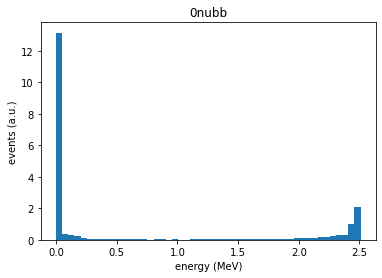

In [38]:
#Getting energy of the tracks
energy_0nubb = tracks_0nubb.energy

plt.hist(energy_0nubb, bins = 50, density = True)
plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.show()

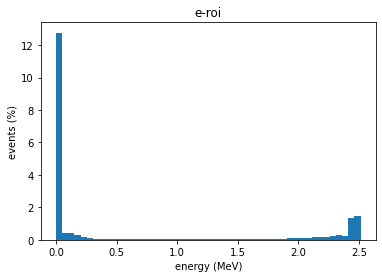

In [39]:
#Getting energy of the tracks
energy_selectron = tracks_selectron.energy

plt.hist(energy_selectron, bins = 50, density = True)
plt.xlabel('energy (MeV)')
plt.ylabel('events (%)')
plt.title('e-roi')
plt.show()

In [40]:
#Check limits of the Energy ROI 

emin = 2.40
emax = 2.54

In [41]:
#Selecting events in the ROI
tracks_0nubb_ROI = tracks_0nubb[(tracks_0nubb.energy >= emin) & (tracks_0nubb.energy <= emax)]
tracks_0nubb_ROIovlp1trackfid = tracks_0nubb_ovlp1trackfid[(tracks_0nubb_ovlp1trackfid.energy >= emin) & (tracks_0nubb_ovlp1trackfid.energy <= emax)]


In [42]:

tracks_selectron_ROI = tracks_selectron[(tracks_selectron.energy >= emin) & (tracks_selectron.energy <= emax)]
tracks_selectron_ROIovlp1trackfid = tracks_selectron_ovlp1trackfid[(tracks_selectron_ovlp1trackfid.energy >= emin) & (tracks_selectron_ovlp1trackfid.energy <= emax)]


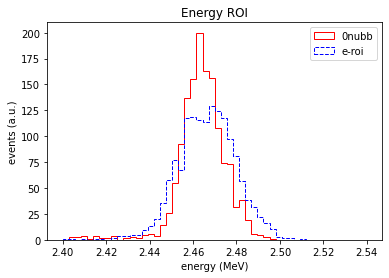

In [43]:
energy_0nubb = tracks_0nubb_ROIovlp1trackfid.energy
energy_selectron = tracks_selectron_ROIovlp1trackfid.energy

plt.hist(energy_0nubb, bins = 50, range = (emin, emax), color='red', histtype='step', label = '0nubb')
plt.hist(energy_selectron, bins = 50, range = (emin, emax), color='blue', histtype='step', label = 'e-roi', linestyle='dashed')

plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('Energy ROI')
plt.legend(loc=1);
plt.show()

In [44]:
#Checking total amount of events, after ROI selection
nevents_0nubb_ROI = tracks_0nubb_ROI.event.nunique()
Enevents_0nubb_ROI = np.sqrt(nevents_0nubb_ROI)
nevents_0nubb_ROIovlp1trackfid = tracks_0nubb_ROIovlp1trackfid.event.nunique()
Enevents_0nubb_ROIovlp1trackfid = np.sqrt(nevents_0nubb_ROIovlp1trackfid)


ratio_ROIovlp1trackfid_0nubb = 100*nevents_0nubb_ROIovlp1trackfid/nevents_0nubb_ovlp1trackfid
Eratio_ROIovlp1trackfid_0nubb = myef.ratio_error(ratio_ROIovlp1trackfid_0nubb, nevents_0nubb_ROIovlp1trackfid, nevents_0nubb_ovlp1trackfid, 
                                             Enevents_0nubb_ROIovlp1trackfid, Enevents_0nubb_ovlp1trackfid)

eff_ROIovlp1trackfid_0nubb = 100*nevents_0nubb_ROIovlp1trackfid/nevents_0nubb_total
Eeff_ROIovlp1trackfid_0nubb = myef.ratio_error(eff_ROIovlp1trackfid_0nubb, nevents_0nubb_ROIovlp1trackfid, nevents_0nubb_total, 
                                             Enevents_0nubb_ROIovlp1trackfid, Enevents_0nubb_total)

  
print('--------------------------0nubb-------------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_0nubb_total}        ')
print(f'FIDUCIAL   {nevents_0nubb_fiducial}                ---      {ratio_fiducial_0nubb} +- {Eratio_fiducial_0nubb}%')
print(f'1TRACK.    {nevents_0nubb_1trackfid}        {ratio_1trackfid_0nubb}+- {Eratio_1trackfid_0nubb}% {eff_1trackfid_0nubb} +- {Eeff_1trackfid_0nubb}%')
print(f'OVLP       {nevents_0nubb_ovlp1trackfid}        {ratio_ovlp1trackfid_0nubb}+- {Eratio_ovlp1trackfid_0nubb}%   {eff_ovlp1trackfid_0nubb} +- {Eeff_ovlp1trackfid_0nubb}%')
print(f'ROI        {nevents_0nubb_ROIovlp1trackfid}        {ratio_ROIovlp1trackfid_0nubb}+- {Eratio_ROIovlp1trackfid_0nubb}%   {eff_ROIovlp1trackfid_0nubb} +- {Eeff_ROIovlp1trackfid_0nubb}%')
print('--------!--------------!----------------!----------------')
print(' ')

--------------------------0nubb-------------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9785        
FIDUCIAL   6679                ---      68.25753704649975 +- 1.0833833465375287%
1TRACK.    1664        24.913909267854468+- 0.6826068113927476% 17.005620848237097 +- 0.4509404497763844%
OVLP       1467        88.1610576923077+- 3.157378212548764%   14.992335206949413 +- 0.4197480368941494%
ROI        1403        95.6373551465576+- 3.5712858506688914%   14.3382728666326 +- 0.409320804813374%
--------!--------------!----------------!----------------
 


In [45]:
nevents_selectron_ROI = tracks_selectron_ROI.event.nunique()
Enevents_selectron_ROI = np.sqrt(nevents_selectron_ROI)
nevents_selectron_ROIovlp1trackfid = tracks_selectron_ROIovlp1trackfid.event.nunique()
Enevents_selectron_ROIovlp1trackfid = np.sqrt(nevents_selectron_ROIovlp1trackfid)

ratio_ROIovlp1trackfid_selectron = 100*nevents_selectron_ROIovlp1trackfid/nevents_selectron_ovlp1trackfid
Eratio_ROIovlp1trackfid_selectron = myef.ratio_error(ratio_ROIovlp1trackfid_selectron, nevents_selectron_ROIovlp1trackfid, nevents_selectron_ovlp1trackfid, 
                                             Enevents_selectron_ROIovlp1trackfid, Enevents_selectron_ovlp1trackfid)

eff_ROIovlp1trackfid_selectron = 100*nevents_selectron_ROIovlp1trackfid/nevents_selectron_total
Eeff_ROIovlp1trackfid_selectron = myef.ratio_error(eff_ROIovlp1trackfid_selectron, nevents_selectron_ROIovlp1trackfid, nevents_selectron_total,
                                                   Enevents_selectron_ROIovlp1trackfid, Enevents_selectron_total)
  
print('--------------------------SElectron---------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_selectron_total}        ')
print(f'FIDUCIAL   {nevents_selectron_fiducial}                ---      {ratio_fiducial_selectron} +- {Eratio_fiducial_selectron}%')
print(f'1TRACK.    {nevents_selectron_1trackfid}        {ratio_1trackfid_selectron}+- {Eratio_1trackfid_selectron}% {eff_1trackfid_selectron} +- {Eeff_1trackfid_selectron}%')
print(f'OVLP       {nevents_selectron_ovlp1trackfid}        {ratio_ovlp1trackfid_selectron}+- {Eratio_ovlp1trackfid_selectron}%   {eff_ovlp1trackfid_selectron} +- {Eeff_ovlp1trackfid_selectron}%')
print(f'ROI        {nevents_selectron_ROIovlp1trackfid}        {ratio_ROIovlp1trackfid_selectron}+- {Eratio_ROIovlp1trackfid_selectron}%   {eff_ROIovlp1trackfid_selectron} +- {Eeff_ROIovlp1trackfid_selectron}%')
print('--------!--------------!----------------!----------------')

--------------------------SElectron---------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9547        
FIDUCIAL   6293                ---      65.9159945532628 +- 1.0703013436881332%
1TRACK.    1680        26.696329254727473+- 0.6841782341457081% 17.597150937467266 +- 0.4655712119033691%
OVLP       1632        97.14285714285714+- 3.376302253889748%   17.094375196396776 +- 0.45789001317588907%
ROI        1504        92.15686274509804+- 3.2940615784027503%   15.753639886875458 +- 0.43704315606734817%
--------!--------------!----------------!----------------


## Representing RECO vs TRUE

True information taken from the deconv. files (prior skeletonization)

In [46]:
#0nubb hit files taken from FULLSIM simulations
hits_list_0nubb = []
filepath_0nubb_hits = filepath+'0nubb/hits/'

filename_0nubb_hits = '/Users/halmamol/NEXT/files/NEXT100/beershebaDS_202012/0nubb/hits/next100.0nubb.1.deconv.h5'
h5file = tb.open_file(filename_0nubb_hits)
h5file

File(filename=/Users/halmamol/NEXT/files/NEXT100/beershebaDS_202012/0nubb/hits/next100.0nubb.1.deconv.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=4, complib='zlib', shuffle=True, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/Run (Group) ''
/Run/events (Table(0,), shuffle, zlib(4)) 'event info table'
  description := {
  "evt_number": Int32Col(shape=(), dflt=0, pos=0),
  "timestamp": UInt64Col(shape=(), dflt=0, pos=1)}
  byteorder := 'little'
  chunkshape := (5461,)
/Run/runInfo (Table(0,), shuffle, zlib(4)) 'run info table'
  description := {
  "run_number": Int32Col(shape=(), dflt=0, pos=0)}
  byteorder := 'little'
  chunkshape := (16384,)

In [50]:
#0nubb files
true_list_0nubb = []
filepath_0nubb_true = filepath_0nubb_hits

#loop over all the files, to read 'HITS' information
for nfile in range(1,max0nubbf):
    
    filename_0nubb_true = f'/Users/halmamol/NEXT/files/NEXT100/beershebaFS/0nubb/hits/next100.0nubb.{nfile}.deconv.h5'

    try:
        readfile_true_0nubb = pd.read_hdf(filename_0nubb_true, 'MC/particles')
    except:
        print('File {} not good'.format(filename_0nubb_true))
        continue
        
    true_list_0nubb.append(readfile_true_0nubb)
    
#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

true_0nubb = pd.concat([dt for dt in true_list_0nubb]) 
true_0nubb.columns  

Index(['event_id', 'particle_id', 'particle_name', 'primary', 'mother_id',
       'initial_x', 'initial_y', 'initial_z', 'initial_t', 'final_x',
       'final_y', 'final_z', 'final_t', 'initial_volume', 'final_volume',
       'initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
       'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
       'kin_energy', 'length', 'creator_proc', 'final_proc'],
      dtype='object')

In [51]:
true_0nubb_primary = true_0nubb[true_0nubb.primary == True]
true_0nubb_primary_part1 = true_0nubb_primary[true_0nubb_primary.particle_id == 1]
true_0nubb_primary_part2 = true_0nubb_primary[true_0nubb_primary.particle_id == 2]
true_0nubb_event0 = true_0nubb[true_0nubb.event_id == 0]

Blobs assigned by proximity, where Blob1 is the one with highest energy

In [52]:
diff_b1_x_0nubb, diff_b1_y_0nubb, diff_b1_z_0nubb = [], [], []
diff_b2_x_0nubb, diff_b2_y_0nubb, diff_b2_z_0nubb = [], [], []

reco_0nubb_e = []

ntracks_asel_0nubb = []

diff_b1_x_0nubb, diff_b1_y_0nubb, diff_b2_x_0nubb, diff_b2_y_0nubb, reco_0nubb_e, ntracks_asel_0nubb = myrvt.blobassignation_wtrack(true_0nubb, tracks_0nubb_ROIovlp1trackfid, 'signal')


Total events = 1369
Events 12 = 678 (49.525200876552226%)
Events 21 = 691 (50.474799123447774%)
Events NA = 0 (0.0%)


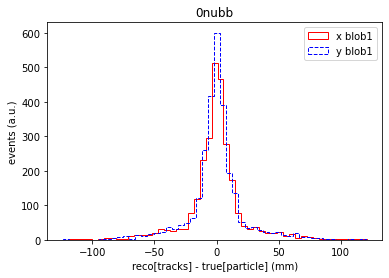

In [53]:
plt.hist(diff_b1_x_0nubb, bins = 50, color='red', histtype='step', label = 'x blob1')
plt.hist(diff_b1_y_0nubb, bins = 50, color='blue', histtype='step', label = 'y blob1', linestyle='dashed')

plt.xlabel('reco[tracks] - true[particle] (mm)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

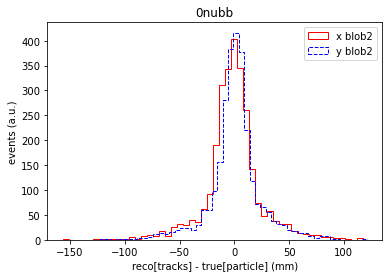

In [54]:
plt.hist(diff_b2_x_0nubb, bins = 50, color='red', histtype='step', label = 'x blob2')
plt.hist(diff_b2_y_0nubb, bins = 50, color='blue', histtype='step', label = 'y blob2', linestyle='dashed')

plt.xlabel('reco[tracks] - true[particle] (mm)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

In [55]:
#single electron files
true_list_selectron = []
filepath_selectron_true = filepath+'e-_roi/hits/'

#loop over all the files, to read 'HITS' information
for nfile in range(1,max0nubbf):
    
    filename_selectron_true = f'/Users/halmamol/NEXT/files/NEXT100/beershebaFS/e-_roi/hits/next100.e-_roi.{nfile}.deconv.h5'

    try:
        readfile_true_selectron = pd.read_hdf(filename_selectron_true, 'MC/particles')
    except:
        print('File {} not good'.format(filename_selectron_true))
        continue
        
    true_list_selectron.append(readfile_true_selectron)
    
#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

true_selectron = pd.concat([dt for dt in true_list_selectron]) 
true_selectron.columns  

Index(['event_id', 'particle_id', 'particle_name', 'primary', 'mother_id',
       'initial_x', 'initial_y', 'initial_z', 'initial_t', 'final_x',
       'final_y', 'final_z', 'final_t', 'initial_volume', 'final_volume',
       'initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
       'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
       'kin_energy', 'length', 'creator_proc', 'final_proc'],
      dtype='object')

In [56]:
true_selectron_primary = true_selectron[true_selectron.primary == True]

true_selectron_primary_part1 = true_selectron_primary[true_selectron_primary.particle_id == 1]
true_selectron_primary_part2 = true_selectron_primary[true_selectron_primary.particle_id == 2]

In [57]:
diff_b1_x_selectron, diff_b1_y_selectron, diff_b1_z_selectron = [], [], []
diff_b2_x_selectron, diff_b2_y_selectron, diff_b2_z_selectron = [], [], []

reco_selectron_e = []

ntracks_asel_selectron = []

diff_b1_x_selectron, diff_b1_y_selectron, diff_b2_x_selectron, diff_b2_y_selectron, reco_selectron_e , ntracks_asel_0nubb= myrvt.blobassignation_wtrack(true_selectron, tracks_selectron_ROIovlp1trackfid, 'bkg')

Total events = 1465
Events 12 = 144 (9.829351535836178%)
Events 21 = 1321 (90.17064846416382%)
Events NA = 0 (0.0%)


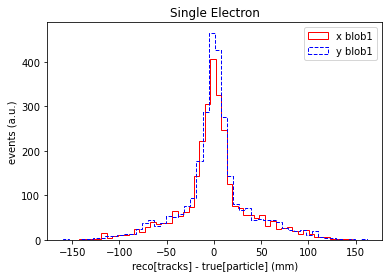

0.6477963738215917

In [58]:
plt.hist(diff_b1_x_selectron, bins = 50, color='red', histtype='step', label = 'x blob1')
plt.hist(diff_b1_y_selectron, bins = 50, color='blue', histtype='step', label = 'y blob1', linestyle='dashed')

plt.xlabel('reco[tracks] - true[particle] (mm)')
plt.ylabel('events (a.u.)')
plt.title('Single Electron')
plt.legend(loc=1);
plt.show()
(np.mean(diff_b1_x_selectron)+np.mean(diff_b1_y_selectron))/2

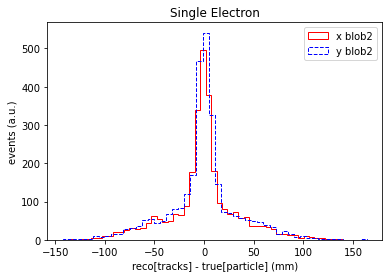

-1.1233041402187722

In [59]:
plt.hist(diff_b2_x_selectron, bins = 50, color='red', histtype='step', label = 'x blob2')
plt.hist(diff_b2_y_selectron, bins = 50, color='blue', histtype='step', label = 'y blob2', linestyle='dashed')

plt.xlabel('reco[tracks] - true[particle] (mm)')
plt.ylabel('events (a.u.)')
plt.title('Single Electron')
plt.legend(loc=1);
plt.show()

(np.mean(diff_b2_x_selectron)+np.mean(diff_b2_y_selectron))/2

In [60]:
npz_file = f'/Users/halmamol/NEXT/NBarrays/recovstrue_NEXT100_DETSIM_R{blobR}mm{testID}_lin'
np.savez(npz_file, diff_b1_x_0nubb=diff_b1_x_0nubb, diff_b1_y_0nubb=diff_b1_y_0nubb, diff_b1_z_0nubb=diff_b1_z_0nubb,
          diff_b2_x_0nubb=diff_b2_x_0nubb, diff_b2_y_0nubb=diff_b2_y_0nubb, diff_b2_z_0nubb=diff_b2_z_0nubb,
         diff_b1_x_selectron=diff_b1_x_selectron, diff_b1_y_selectron=diff_b1_y_selectron, diff_b1_z_selectron=diff_b1_z_selectron,
         diff_b2_x_selectron=diff_b2_x_selectron, diff_b2_y_selectron=diff_b2_y_selectron, diff_b2_z_selectron=diff_b2_z_selectron)


### Blob energies

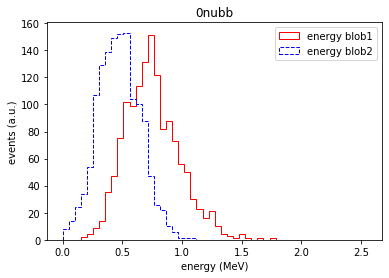

In [61]:
plt.hist(reco_0nubb_e[1], bins = 50, range = (0, 2.55), color='red', histtype='step', label = 'energy blob1')
plt.hist(reco_0nubb_e[2], bins = 50, range = (0, 2.55), color='blue', histtype='step', label = 'energy blob2', linestyle='dashed')

plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

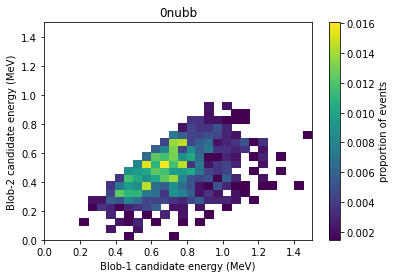

In [62]:
weights = myhf.get_weights(reco_0nubb_e[1], True)

plt.hist2d(reco_0nubb_e[1], reco_0nubb_e[2], weights= weights, bins=(30, 30), range=((0, 1.5), (0, 1.5)), cmap='viridis', cmin=0.001)
plt.xlabel('Blob-1 candidate energy (MeV)')
plt.ylabel('Blob-2 candidate energy (MeV)')
plt.title('0nubb')
#plt.xlim((0.0,1.5))
plt.colorbar(label='proportion of events')

In [63]:
ntracks_asel_0nubb, ntracks_asel_selectron = [], []


for n in range(0,len(reco_0nubb_e[3])):
    ntracks_asel_0nubb.append(tracks_0nubb[tracks_0nubb.event == reco_0nubb_e[3][n]].numb_of_tracks.values[0])

for n in range(0,len(reco_selectron_e[3])):
    ntracks_asel_selectron.append(tracks_selectron[tracks_selectron.event == reco_selectron_e[3][n]].numb_of_tracks.values[0])
    #print(f'n value = {n}, event = {reco_selectron_e[3][n]}, added {len(ntracks_asel_selectron)}')


In [64]:
print(len(reco_0nubb_e[3]))
print(len(ntracks_asel_0nubb))

1369
1369


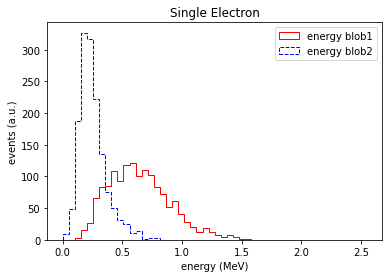

In [65]:
plt.hist(reco_selectron_e[1], bins = 50, range = (0, 2.55),color='red', histtype='step', label = 'energy blob1')
plt.hist(reco_selectron_e[2], bins = 50, range = (0, 2.55), color='blue', histtype='step', label = 'energy blob2', linestyle='dashed')

plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('Single Electron')
plt.legend(loc=1);
plt.show()

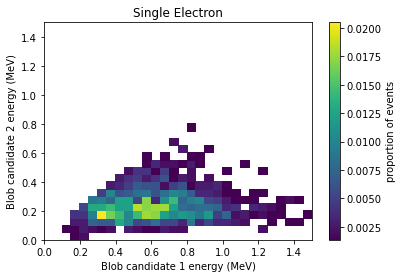

In [66]:
weights = myhf.get_weights(reco_selectron_e[1], True)

plt.hist2d(reco_selectron_e[1], reco_selectron_e[2], weights=weights, bins=(30, 30), range=((0, 1.5), (0, 1.5)), cmap='viridis', cmin=0.001)
plt.xlabel('Blob candidate 1 energy (MeV)')
plt.ylabel('Blob candidate 2 energy (MeV)')
plt.title('Single Electron')
plt.colorbar(label='proportion of events')

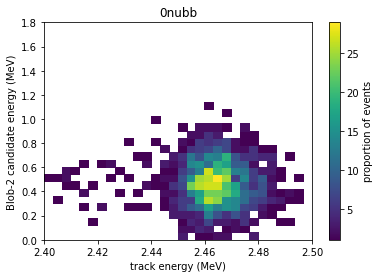

In [67]:
weights = myhf.get_weights(reco_0nubb_e[0], True)

plt.hist2d(reco_0nubb_e[0], reco_0nubb_e[2], bins=(30, 30), range=((2.4, 2.5), (0, 1.8)), cmap='viridis', cmin=0.001)
plt.xlabel('track energy (MeV)')
plt.ylabel('Blob-2 candidate energy (MeV)')
plt.title('0nubb')
#plt.xlim((0.0,1.5))
plt.colorbar(label='proportion of events')

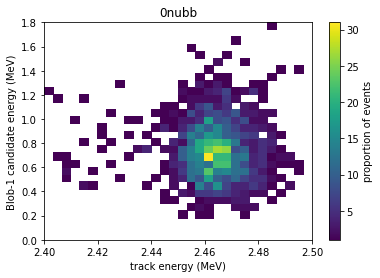

In [68]:
weights = myhf.get_weights(reco_0nubb_e[0], True)

plt.hist2d(reco_0nubb_e[0], reco_0nubb_e[1], bins=(30, 30), range=((2.4, 2.5), (0, 1.8)), cmap='viridis', cmin=0.001)
plt.xlabel('track energy (MeV)')
plt.ylabel('Blob-1 candidate energy (MeV)')
plt.title('0nubb')
#plt.xlim((0.0,1.5))
plt.colorbar(label='proportion of events')

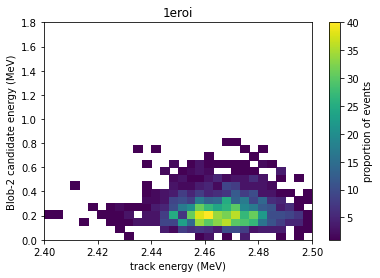

In [69]:
weights = myhf.get_weights(reco_0nubb_e[0], True)

plt.hist2d(reco_selectron_e[0], reco_selectron_e[2], bins=(30, 30), range=((2.4, 2.5), (0, 1.8)), cmap='viridis', cmin=0.001)
plt.xlabel('track energy (MeV)')
plt.ylabel('Blob-2 candidate energy (MeV)')
plt.title('1eroi')
#plt.xlim((0.0,1.5))
plt.colorbar(label='proportion of events')

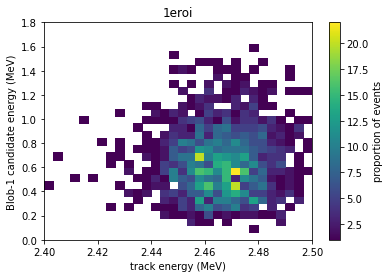

In [70]:
weights = myhf.get_weights(reco_0nubb_e[0], True)

plt.hist2d(reco_selectron_e[0], reco_selectron_e[1], bins=(30, 30), range=((2.4, 2.5), (0, 1.8)), cmap='viridis', cmin=0.001)
plt.xlabel('track energy (MeV)')
plt.ylabel('Blob-1 candidate energy (MeV)')
plt.title('1eroi')
#plt.xlim((0.0,1.5))
plt.colorbar(label='proportion of events')

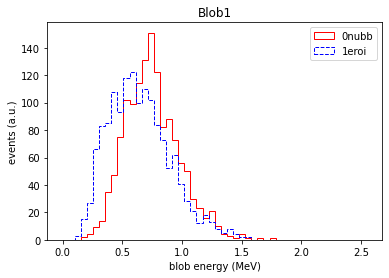

In [71]:
plt.hist(reco_0nubb_e[1], bins = 50, range = (0, 2.55), color='red', histtype='step', label = '0nubb')
plt.hist(reco_selectron_e[1], bins = 50, range = (0, 2.55), color='blue', histtype='step', label = '1eroi', linestyle='dashed')

plt.xlabel('blob energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('Blob1')
plt.legend(loc=1);
plt.show()

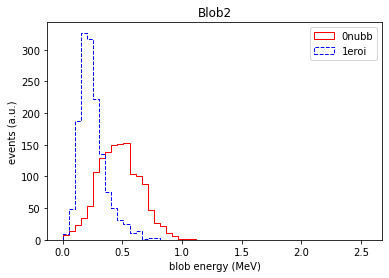

In [72]:
plt.hist(reco_0nubb_e[2], bins = 50, range = (0, 2.55), color='red', histtype='step', label = '0nubb')
plt.hist(reco_selectron_e[2], bins = 50, range = (0, 2.55), color='blue', histtype='step', label = '1eroi', linestyle='dashed')

plt.xlabel('blob energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('Blob2')
plt.legend(loc=1);
plt.show()

## Efficiency Values and FOM Estimation

In [ ]:
plt.hist(reco_0nubb_e[2], bins = 50, histtype='step', label = 'energy track')
plt.xlabel('blob-2 energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.show()

In [ ]:
plt.hist(reco_selectron_e[2], bins = 50, histtype='step', label = 'energy track')
plt.xlabel('blob-2 energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('Single Electron')
plt.show()

print(f'Total events {len(reco_selectron_e[0])}')

Since I need to compare both simulations, I'm going to use the same energy cuts. Besides, they seem reasonable looking into the blob2 energy distribution:

In [ ]:
blobcut_energy=[]
#in MeV
minEcut = 0.010
maxEcut = 0.600
stepsEcut = 0.010

#defining the vector with the cut values
blobcut_energy=myef.blobthreshold(minEcut,maxEcut,stepsEcut)

In [ ]:
if(len(reco_0nubb_e[0])!=len(reco_0nubb_e[1])):
    print(len(reco_0nubb_e[0]))
    print(len(reco_0nubb_e[1]))
    test = reco_0nubb_e[0][:-1].copy()
    print(len(test))
    reco_0nubb_e[0] = test

Now I'm going to take the information from reco_selectron_e[][], to see how many events with each cut I get:

In [ ]:
blobcut_energy_nevents_0nubb, blobcut_energy_nevents_selectron = [], [] 

blobcut_energy_nevents_0nubb = myef.nevents_afterthreshold(blobcut_energy, reco_0nubb_e)
blobcut_energy_nevents_selectron = myef.nevents_afterthreshold(blobcut_energy, reco_selectron_e)

blobcut_energy_nevents_0nubb = np.array(blobcut_energy_nevents_0nubb, dtype=np.float)
blobcut_energy_nevents_selectron = np.array(blobcut_energy_nevents_selectron, dtype=np.float)

Create now arrays containing the statistical uncertainty (sqrt from total amount of events)

In [ ]:
blobcut_energy_nevents_0nubb_error, blobcut_energy_nevents_selectron_error= [], []

blobcut_energy_nevents_0nubb_error = myef.sqrterror_array(blobcut_energy_nevents_0nubb)
blobcut_energy_nevents_selectron_error = myef.sqrterror_array(blobcut_energy_nevents_selectron)

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(blobcut_energy,blobcut_energy_nevents_0nubb, yerr=blobcut_energy_nevents_0nubb_error, fmt = '-r')
plt.ylabel('accepted events (a.u.)')
plt.xlabel('blob-2 energy threshold (MeV)')
#plt.title('Cut efficiency')

Now that I have checked the accepted events for each energy cut, I'm going to compute the efficiency/background values:

In [ ]:
fom_error, e_error, b_error = [], [], []

e, b, fom, e_error, b_error, fom_error = myef.efficiencyterms(blobcut_energy_nevents_0nubb, blobcut_energy_nevents_selectron, 
                            blobcut_energy_nevents_0nubb_error, blobcut_energy_nevents_selectron_error,
                            reco_0nubb_e, reco_selectron_e)

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(1-b,e, xerr=b_error, yerr=e_error, fmt = '-r')
plt.ylabel('signal efficiency')
plt.xlabel('background rejection')
#plt.title('Cut efficiency')

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(blobcut_energy,fom, yerr=fom_error,fmt = '-r')
plt.xlabel('blob-2 energy threshold (MeV)')
plt.ylabel('f.o.m.=e/sqrt(b)')
#plt.title('Cut efficiency')

In [ ]:
myef.best_fom(e,b,fom,blobcut_energy)

In [ ]:
npz_file = f'/Users/halmamol/NEXT/NBarrays/ntracks_NEXT100_DETSIM_R{blobR}mm_lin'
np.savez(npz_file, ntracks_0nubb=ntracks_0nubb, ntracks_eroi=ntracks_eroi)

In [ ]:
npz_file = f'/Users/halmamol/NEXT/NBarrays/ereco_NEXT100_DETSIM_R{blobR}mm{testID}_lin'
np.savez(npz_file, reco_0nubb_e=reco_0nubb_e, reco_selectron_e=reco_selectron_e)

In [ ]:
npz_file = f'/Users/halmamol/NEXT/NBarrays/fom_NEXT100_DETSIM_R{blobR}mm{testID}_lin'
np.savez(npz_file, e=e, b=b, fom=fom, e_error=e_error, b_error=b_error, fom_error=fom_error, blobcut_energy = blobcut_energy)

In [ ]:
npz_file = f'/Users/halmamol/NEXT/NBarrays/trackpos_NEXT100_DETSIM_R{blobR}mm_lin'
np.savez(npz_file, track_0nubb_zmin=track_0nubb_zmin, track_0nubb_zmax=track_0nubb_zmax, track_0nubb_rmax = track_0nubb_rmax,
        track_selectron_zmin=track_selectron_zmin, track_selectron_zmax=track_selectron_zmin, track_selectron_rmax = track_selectron_rmax)


### Testing selected events

In [ ]:
len(reco_0nubb_e[2])

In [ ]:
#events_noaccept = []
#for i in range(len(reco_selectron_e[1])):
    #if reco_selectron_e[1][i] > 0.45 and reco_selectron_e[2][i] < 0.40:
        #print(f'Event {reco_selectron_e[3][i]}, Blob 1 energy {reco_selectron_e[1][i]} and Blob 2 energy {reco_selectron_e[2][i]}') 
        #events_noaccept.append(reco_selectron_e[3][i])
#events_noaccept